## Project
### Human vs ChatGPT
#### Satyar Foroughi,  April 2023

In [ ]:
# In order to run this notebook in google collab
# you need to run the following commands

# !pip install datasets

# !pip install torchtext==0.6.0  # newer versions of torchtext changed some libraries and
                                 # I couldn't figure out how to use them.

In [ ]:
import numpy as np
import pandas as pd
import json
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import spacy
import matplotlib.pyplot as plt
import time
import random
from torchtext.data.utils import get_tokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
# Basic RNN which was used
class RNN(torch.nn.Module):
    '''
    Basic RNN (LSTM) with 1 hidden layer.
    '''
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, answer):
        embedded = self.embedding(answer)
        output, (hidden, cell) = self.rnn(embedded)
        hidden.squeeze_(0)
        output = self.fc(hidden)
        return output

In [ ]:
# A bit more complicated RNN, which was not used due to GPU limits
# Performance is not known due to the limit
class RNN_2(torch.nn.Module):
    '''
    RNN (LSTM) with 2 bidirectional hidden layers with dropout rate
    '''
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout_rate):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 num_layers=n_layers,
                                 bidirectional=True,
                                 dropout=dropout_rate if n_layers > 1 else 0)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim) 
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, answer):
        embedded = self.dropout(self.embedding(answer))
        output, (hidden, cell) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)        
        output = self.fc(self.dropout(hidden))
        return output

In [ ]:
def count_special_chars(df, replace=False):
    """
    Counts the number of rows in a DataFrame that contain special characters in the 'answer' or 'question' columns.
    If replace=True, replaces special characters. Returns the numbers respectively.
    """
    
    if (replace==True):
        # replace special characters in 'answer' column
        df['answer'] = df['answer'].str.replace('\n', ' ')
        df['answer'] = df['answer'].str.replace('\t', ' ')
        df['answer'] = df['answer'].str.replace('\r', '')
        df['answer'] = df['answer'].str.replace('\u202f', ' ')
        
        # replace special characters in 'question' column
        df['question'] = df['question'].str.replace('\n', ' ')
        df['question'] = df['question'].str.replace('\t', ' ')
        df['question'] = df['question'].str.replace('\r', '')
        df['question'] = df['question'].str.replace('\u202f', ' ')
        
                # new-line
    mask_hum = ((df['answer'].str.contains('\n'))
                # tab
                | (df['answer'].str.contains('\t'))
                # carriage return
                | (df['answer'].str.contains('\r'))
                # narrow no-break space
                | (df['answer'].str.contains('\u202f'))) & (df['target'] == 0)

    mask_gpt = ((df['answer'].str.contains('\n'))
                | (df['answer'].str.contains('\t'))
                | (df['answer'].str.contains('\r'))
                | (df['answer'].str.contains('\u202f'))) & (df['target'] == 1)

    mask_ques = ((df['question'].str.contains('\n'))
                 | (df['question'].str.contains('\t'))
                 | (df['question'].str.contains('\r'))
                 | (df['question'].str.contains('\u202f')))
    

    print("human answers with special characters:", len(df[mask_hum]))
    print("chatgpt answers with special characters:", len(df[mask_gpt]))
    print("questions with special characters:", len(df[mask_ques]))
    
    return len(df[mask_hum]), len(df[mask_gpt]), len(df[mask_ques])

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Compute the accuracy of the given model, with the given data.
    '''

    with torch.no_grad():
        total_accuracy, num_batches = 0, 0
        correct_pred, num_examples = 0, 0

        for _, batch in enumerate(data_loader):

            answer, _ = batch.answer
            target = batch.target.to(device)

            odds = model(answer)
            probs = torch.sigmoid(odds)
            predicted_labels = (probs > 0.5).float()

            # Convert tensors to NumPy arrays for easier operations
            predicted_labels_np = predicted_labels.cpu().numpy()
            target_np = target.cpu().numpy()
            
            # Calculate accuracy for the current batch
            corrects = [1 for i, pred in enumerate(predicted_labels_np) if (target_np[i]==pred)]
            correct_pred = sum(corrects)
            num_examples = target_np.shape[0]

            batch_accuracy = (correct_pred / num_examples) * 100

            total_accuracy += batch_accuracy
            num_batches += 1

    return total_accuracy / num_batches


In [ ]:
# These following lines of code are if you want to use a model that takes both question and answer as inputs
# As mentioned in the final report and presentation, this approach didn't yield any promising results
# However, the format of the main parts of the code would be different. These are commented out
'''
class RNN(torch.nn.Module):

    def __init__(self, input_dim_q, input_dim_a, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding_question = torch.nn.Embedding(input_dim_q, embedding_dim)
        self.embedding_answer = torch.nn.Embedding(input_dim_a, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, question, question_length, answer, answer_length):        
        embedded_question = self.embedding_question(question)        
        embedded_answer = self.embedding_answer(answer)        
        embedded = torch.cat((embedded_question, embedded_answer), dim=0)        
        sorted_lengths, sorted_idx = torch.sort(question_length + answer_length, descending=True)
        embedded = embedded[:, sorted_idx]        
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, sorted_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed)
        hidden.squeeze_(0)        
        _, original_idx = torch.sort(sorted_idx)
        output = self.fc(hidden[original_idx])
        return output
        
def get_accuracy(model, data_loader, device):

    with torch.no_grad():
        total_accuracy, num_batches = 0, 0
        correct_pred, num_examples = 0, 0


        for _, batch in enumerate(data_loader):

            question, question_length = batch.question
            answer, answer_length = batch.answer
            target = batch.target.to(device)

            odds = model(question, question_length, answer, answer_length)
            probs = torch.sigmoid(odds)
            predicted_labels = (probs > 0.5).float()

            predicted_labels_np = predicted_labels.cpu().numpy()
            target_np = target.cpu().numpy()

            corrects = [1 for i, pred in enumerate(predicted_labels_np) if (target_np[i]==pred)]
            correct_pred = sum(corrects)
            num_examples = target_np.shape[0]

            batch_accuracy = (correct_pred / num_examples) * 100

            total_accuracy += batch_accuracy
            num_batches += 1

    return total_accuracy / num_batches
    
    
input_dim_q = len(question_field.vocab)
input_dim_a = len(answer_field.vocab)

model = RNN(input_dim_q=input_dim_q,
            input_dim_a=input_dim_a,
            embedding_dim=params['emb_dim'],
            hidden_dim=params['hid_dim'],
            output_dim=params['out_dim'] # could use 1 for binary classification
)



model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

start_time = time.time()
n_ep = params['epochs']

for epoch in range(params['epochs']):
    model.train()
    for batch_id, batch_data in enumerate(train_loader):
        
        question, q_length = batch_data.question
        answer, a_length = batch_data.answer
        target = batch_data.target.to(DEVICE)

        odds = model(question, q_length, answer, a_length)
        probs = torch.sigmoid(odds)
        predicted_labels = (probs > 0.5).float()
        loss = nn.BCEWithLogitsLoss()(odds, target.unsqueeze(1).to(odds.dtype))
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if not batch_id % 50:
            print (f'Epoch: {epoch+1:03d}/{n_ep:03d} | '
                   f'Batch {batch_id:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')
            
            predicted_labels_np = predicted_labels.cpu().numpy()
            target_np = target.cpu().numpy()

            corrects = [1 for i, pred in enumerate(predicted_labels_np) if (target_np[i]==pred)]
            correct_pred = sum(corrects)
            num_examples = target_np.shape[0]

            print(f"{correct_pred} out of {num_examples}")
            print("-----------------------------------------------------------")

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{get_accuracy(model, train_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {get_accuracy(model, test_loader, DEVICE):.2f}%')
'''

# Note that on top of replacing the desired blocks with the above,
# some lines which are mentioned throughout the notebook (labeled "for approach 1")
# need to be uncommented.

'\nclass RNN(torch.nn.Module):\n\n    def __init__(self, input_dim_q, input_dim_a, embedding_dim, hidden_dim, output_dim):\n        super().__init__()\n\n        self.embedding_question = torch.nn.Embedding(input_dim_q, embedding_dim)\n        self.embedding_answer = torch.nn.Embedding(input_dim_a, embedding_dim)\n        self.rnn = torch.nn.LSTM(embedding_dim,\n                                 hidden_dim)        \n        self.fc = torch.nn.Linear(hidden_dim, output_dim)\n\n    def forward(self, question, question_length, answer, answer_length):        \n        embedded_question = self.embedding_question(question)        \n        embedded_answer = self.embedding_answer(answer)        \n        embedded = torch.cat((embedded_question, embedded_answer), dim=0)        \n        sorted_lengths, sorted_idx = torch.sort(question_length + answer_length, descending=True)\n        embedded = embedded[:, sorted_idx]        \n        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, s

In [ ]:
torch.manual_seed(0)

params = {
    'emb_dim': 256,
    'hid_dim': 256,
    'out_dim': 1,
    'n_layers': 2,
    'dropout': 0.35,
    'lr': 0.01,
    'epochs': 13,
    'batch_size': 128,
    'test_prc': 0.2,
    'num_filters': 100,          # For a CNN which I decided to not include
    'filter_sizes': [2, 3, 4],   # For a CNN which I decided to not include
}

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Full dataset with list type columns in human and chatGPT answers
dataset = load_dataset("json", data_files="all.jsonl", split="train")
df_full = dataset.to_pandas()

data = []

# Combining the human and GPT columns into one column "answer" which is type string
# Making sure each question has the same ammount of human and chatGPT answers
for i in range(len(df_full)):
    question = df_full.loc[i, 'question']
    j_min = min(len(df_full['human_answers'][i]), len(df_full['chatgpt_answers'][i]))
    
    for j in range(j_min):
        h_ans = df_full.loc[i, 'human_answers'][j]
        c_ans = df_full.loc[i, 'chatgpt_answers'][j]
        
        data.append({'question': question, 'answer': h_ans, 'target': 0})
        data.append({'question': question, 'answer': c_ans, 'target': 1})

# Making new dataset
df = pd.DataFrame(data)

# Dropping duplicates
df = df.drop_duplicates()

It seems like many chatgpt answers have special characters, but most human answers don't.

In [ ]:
human_answers, chatgpt_answers, _ = count_special_chars(df)

human answers with special characters: 650
chatgpt answers with special characters: 7645
questions with special characters: 0


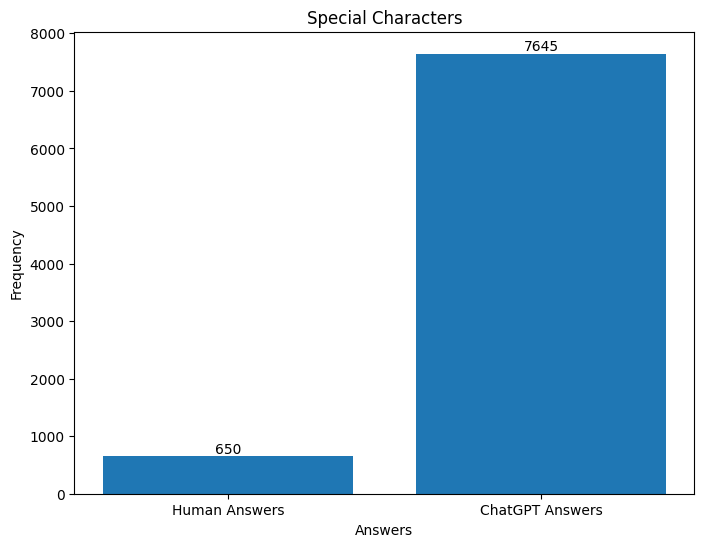

In [ ]:
# Plotting to visualize the difference
labels = ['Human Answers', 'ChatGPT Answers']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(labels, [human_answers, chatgpt_answers])

ax.set_title('Special Characters')

ax.set_xlabel('Answers')
ax.set_ylabel('Frequency')

ax.text(0, human_answers, human_answers, ha='center', va='bottom')
ax.text(1, chatgpt_answers, chatgpt_answers, ha='center', va='bottom')

plt.show()

This could be due to the way the data was collected and the different sources.<br>
Having this significance of a difference could result in noise and bias, <br>
Therefore it could be a good idea to replace these special characters.

In [ ]:
human_answers, chatgpt_answers, _ = count_special_chars(df, replace=True)

human answers with special characters: 0
chatgpt answers with special characters: 0
questions with special characters: 0


In [ ]:
# shuffling the dataset
shuffled_df = df.sample(frac=1, random_state=13)

# For approach 1:
    # save shuffled df as a csv file and use that instead of sh_2.csv
    
# For normal approach:
    # Drop the question column
sh_2 = shuffled_df.drop('question', axis=1)

    # Save as csv
# sh_2.to_csv('sh_2.csv', index=False)

In [ ]:
# question_field = torchtext.data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True) # Approach 1
answer_field = torchtext.data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
label_field = torchtext.data.LabelField(dtype=torch.long)

# fields = [('question', question_field), ('answer', answer_field), ('target', label_field)] # Approach 1
fields = [('answer', answer_field), ('target', label_field)]

dataset = torchtext.data.TabularDataset(path='sh_2.csv', format='csv', skip_header=True, fields=fields)

In [ ]:
# Splitting dataset to training and testing
train_data, test_data = dataset.split(split_ratio=[1-params['test_prc'], params['test_prc']],random_state=random.seed(13))

In [ ]:
# question_field.build_vocab(train_data)  # Approach 1
answer_field.build_vocab(train_data)
label_field.build_vocab(train_data)

# print(f'Vocabulary size: {len(question_field.vocab)}')  # Approach 1
print(f'Vocabulary size: {len(answer_field.vocab)}')
print(f'Number of classes: {len(label_field.vocab)}')

# Note that the way the label field worked, it mapped 0s to 1s and 1s to 0s
# which means it's the opposite of the target column (0s are chatGPT, 1s are human)

Vocabulary size: 83952
Number of classes: 2


In [ ]:
train_loader, test_loader = torchtext.data.BucketIterator.splits(
        (train_data, test_data), 
        batch_size=params['batch_size'],
        sort_within_batch=True,
        sort_key=lambda x: len(x.answer),
        device=DEVICE
)

In [ ]:
input_dim = len(answer_field.vocab)

# Basic RNN
model = RNN(input_dim=input_dim,
            embedding_dim=params['emb_dim'],
            hidden_dim=params['hid_dim'],
            output_dim=params['out_dim']
)

# 2 layer RNN
#model = RNN_2(input_dim=input_dim,
#            embedding_dim=params['emb_dim'],
#            hidden_dim=params['hid_dim'],
#            output_dim=params['out_dim'],
#            n_layers=params['n_layers'],
#            dropout_rate=params['dropout']
#)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

In [ ]:
start_time = time.time()
n_ep = params['epochs']

for epoch in range(n_ep):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        answer, _ = batch_data.answer
        target = batch_data.target.to(DEVICE)

        odds = model(answer)
        probs = torch.sigmoid(odds)
        predicted_labels = (probs > 0.5).float()
        loss = nn.BCEWithLogitsLoss()(odds, target.unsqueeze(1).to(odds.dtype))
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{n_ep:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')
            
            predicted_labels_np = predicted_labels.cpu().numpy()
            target_np = target.cpu().numpy()

            corrects = [1 for i, pred in enumerate(predicted_labels_np) if (target_np[i]==pred)]
            correct_pred = sum(corrects)
            num_examples = target_np.shape[0]

            print(f"{correct_pred} out of {num_examples}")
            print("-----------------------------------------------------------")

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{get_accuracy(model, train_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {get_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 001/013 | Batch 000/285 | Loss: 0.7209
31 out of 128
-----------------------------------------------------------
Epoch: 001/013 | Batch 050/285 | Loss: 0.8517
5 out of 128
-----------------------------------------------------------
Epoch: 001/013 | Batch 100/285 | Loss: 0.7492
44 out of 128
-----------------------------------------------------------
Epoch: 001/013 | Batch 150/285 | Loss: 0.5666
97 out of 128
-----------------------------------------------------------
Epoch: 001/013 | Batch 200/285 | Loss: 0.4061
106 out of 128
-----------------------------------------------------------
Epoch: 001/013 | Batch 250/285 | Loss: 0.2442
115 out of 128
-----------------------------------------------------------
training accuracy: 94.75%
Time elapsed: 0.20 min
Epoch: 002/013 | Batch 000/285 | Loss: 0.1626
121 out of 128
-----------------------------------------------------------
Epoch: 002/013 | Batch 050/285 | Loss: 0.0798
123 out of 128
------------------------------------------------

In [ ]:
nlp = spacy.blank("en")

# Function to test the model on any given text
def predict_BotOrNot(model, text):
    '''
    Function to test a text-classifying model on any given text
    '''
    model.eval()
    
    tokenized = [tok.text for tok in nlp.tokenizer(text)]
    indexed = [answer_field.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor))
    
    return (prediction[0][0].item())

In [ ]:
# Example 1 - chatGPT decribing football
pred = predict_BotOrNot(model, "Football is a popular team sport played between two teams of eleven players, with the objective of scoring goals by kicking a ball into the opposing team's goalpost. The game is played on a rectangular field and involves passing, dribbling, and shooting skills. Football is a highly competitive and physically demanding sport, enjoyed by millions of fans worldwide.")
print(f'Probability of being human: {pred}')

Probability of being human: 0.00014332136197481304


In [ ]:
# Example 2 - Human (me) decribing football
pred = predict_BotOrNot(model, "Football is probably the most popular sport in the world. There are eleven players in each team.")
print(f'Probability of being human: {pred}')

Probability of being human: 0.9733949899673462
